In [1]:
import math
import numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
import sys
import joblib
import warnings
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as Sfs
from sklearn.feature_selection import chi2
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from dateutil.relativedelta import relativedelta
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import plotly.express as px

In [2]:
sns.set()

In [3]:
# Data Import and overview
DATASET_PATH = "../../data/tweets_2020_2021_v2.csv"
df = pd.read_csv(filepath_or_buffer=DATASET_PATH, sep=",")
df = df.sort_values(by='timestamp', ascending=True)
df.tail()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,...,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority,topics_cleaned
612261,612261,612261,612261,612261,1477036834261770241,…. them crawfish was so good yall lmfao,2021-12-31 21:59:57+00:00,795707439219884037,0,0,...,Night,2021-52,4,0,2,1,2,0,5,NaN
98252,98252,98252,98252,98252,1477036835603836932,Damn all the freaks are at the New Bev right n...,2021-12-31 21:59:58+00:00,34679503,26,0,...,Night,2021-52,4,0,2,1,1,0,13,NaN
1072384,1072384,1072384,1072384,1072384,1477036838217035777,Fast And Professional Vehicle Lockout Service ...,2021-12-31 21:59:58+00:00,210241982,0,0,...,Night,2021-52,4,0,2,1,0,0,11,NaN
1072385,1072385,1072385,1072385,1072385,1477036840024567809,Very much this https://t.co/b3bgtstLfr,2021-12-31 21:59:59+00:00,883576549,3,0,...,Night,2021-52,4,0,2,1,1,0,9,NaN
1072386,1072386,1072386,1072386,1072386,1477036841933185025,Best thread ever https://t.co/EBo4JkTCx4,2021-12-31 21:59:59+00:00,131371694,0,0,...,Night,2021-52,4,0,2,1,2,0,12,NaN


In [4]:
vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'topics_ids', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc', 'popularity', 'followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
tweet_vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc', 'topics_ids']
users_vars = ['followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
num_vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'followers', 'following', 'tweet_count', 'seniority']
cat_vars = ['sentiment_enc', 'verified_enc', 'day_of_week_enc', 'day_phase_enc', 'month_enc']

## Spliting the data by year

In [5]:
df_2020 = df[df['year'] == 2020]
df_2021 = df[df['year'] == 2021]

In [6]:
df_2020.shape

(534942, 35)

In [7]:
df_2021.shape

(537445, 35)

# Machine Learning

### Predicting tweet popularity in 2021 using 2020 data with topics

## Data spliting

In [8]:
num_folds = 7
seed = 7
scoring = 'accuracy'
validation_size = 0.70

In [9]:
df_2020_topics = df_2020[(~df_2020['topics'].isnull()) & (df_2020['topics'] != '')]
df_2020_topics

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,...,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority,topics_cleaned
44,44,44,44,44,1212176426587303936,New Year’s Eve was created by the sun to sell ...,2020-01-01 00:59:15,735991364635217921,10,0,...,Dawn,2020-01,1,6,4,0,2,0,5,Holiday
46,46,46,46,46,1212176422896193537,"Looking at all 0 replies to my very sad ""who's...",2020-01-01 00:59:15,857462622920339456,3,0,...,Dawn,2020-01,1,6,4,0,0,0,4,Brand
35,35,35,35,35,1212176423189909506,and he still cheating https://t.co/zYAQ8wc6Vg,2020-01-01 00:59:15,3322006549,2,1,...,Dawn,2020-01,1,6,4,0,0,0,6,Person
41,41,41,41,41,1212176426088181760,Disgruntled Pope Francis pulls himself free fr...,2020-01-01 00:59:15,858762062,0,0,...,Dawn,2020-01,1,6,4,0,2,0,9,Person
52,52,52,52,52,1212176427845607426,My NASA engineer sister..... I would tell you ...,2020-01-01 00:59:16,1057480999943032832,11,0,...,Dawn,2020-01,1,6,4,0,2,0,3,Brand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154051,154051,154051,154051,154051,1344765260260020224,"This might be more devastating than ""n****r na...",2020-12-31 21:59:57+00:00,206374653,1,0,...,Night,2020-53,4,4,2,0,0,0,11,Brand
679919,679919,679919,679919,679919,1344765260151066624,2020 YOURE a real son of a bitch https://t.co/...,2020-12-31 21:59:57+00:00,387676464,2,1,...,Night,2020-53,4,4,2,0,0,0,10,Music
736687,736687,736687,736687,736687,1344765262147575808,Happy New Year from FreeBikes4KidzMN! Everyone...,2020-12-31 21:59:57+00:00,193418595,2,2,...,Night,2020-53,4,4,2,0,2,0,11,Holiday
803046,803046,803046,803046,803046,1344765266530590722,Wanna give a shoutout to whom ever invented co...,2020-12-31 21:59:58+00:00,988833535,0,0,...,Night,2020-53,4,4,2,0,2,0,9,Interest and Hobbies


In [10]:
df_2021_topics = df_2021[(~df_2021['topics'].isnull()) & (df_2021['topics'] != '')]
df_2021_topics

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,...,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority,topics_cleaned
803053,803053,803053,803053,803053,1344810321270202369,This guy voted for a tax breaks for the riches...,2021-01-01 00:59:00+00:00,93440753,18,3,...,Dawn,2021-53,1,0,4,1,2,1,12,Brand
803052,803052,803052,803052,803052,1344810320485728256,Watching my last sunset of 2020 and anticipati...,2021-01-01 00:59:00+00:00,720858537446879232,16,0,...,Dawn,2021-53,1,0,4,1,2,0,6,Holiday
803058,803058,803058,803058,803058,1344810324223025152,the entire sixers team is on absolute fire and...,2021-01-01 00:59:01+00:00,749805553,3,0,...,Dawn,2021-53,1,0,4,1,0,0,9,TV and Movies
803061,803061,803061,803061,803061,1344810324587905025,Happy New Years Eve🎆 All of our locations will...,2021-01-01 00:59:01+00:00,27752921,0,0,...,Dawn,2021-53,1,0,4,1,2,0,13,Holiday
803060,803060,803060,803060,803060,1344810323350614016,"5, Cancer https://t.co/2BwiZ1FsU3",2021-01-01 00:59:01+00:00,898665696107909120,0,0,...,Dawn,2021-53,1,0,4,1,0,0,4,Interest and Hobbies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120623,120623,120623,120623,120623,1477036814653440006,this is how im coming in 2022 https://t.co/PMS...,2021-12-31 21:59:53+00:00,623803642,1,0,...,Night,2021-52,4,0,2,1,1,0,9,Video Game
1072303,1072303,1072303,1072303,1072303,1477036815085363202,They need a one51 in ATL @cjxbanks,2021-12-31 21:59:53+00:00,1066856094033559553,2,0,...,Night,2021-52,4,0,2,1,1,0,3,Person
1072380,1072380,1072380,1072380,1072380,1477036820130975745,ISO @GemandJamFest car camping pass !!!! Pls RT,2021-12-31 21:59:54+00:00,220200906,3,2,...,Night,2021-52,4,0,2,1,2,0,11,Entities
1072383,1072383,1072383,1072383,1072383,1477036825579507714,No one told me I’d have a real life princess. ...,2021-12-31 21:59:55+00:00,38572410,0,0,...,Night,2021-52,4,0,2,1,2,0,12,Interest and Hobbies


In [11]:
inputs = df_2020_topics[tweet_vars + users_vars]
inputs.columns

Index(['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach',
       'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc',
       'topics_ids', 'followers', 'following', 'tweet_count', 'verified_enc',
       'seniority'],
      dtype='object')

In [12]:
targets = df_2020_topics['popularity']
X_train, X_validation, y_train, y_validation = train_test_split(inputs, targets, test_size=validation_size, random_state=seed, shuffle=True)
X_train

,like_count,retweet_count,quote_count,reply_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc,topics_ids,followers,following,tweet_count,verified_enc,seniority
754046,2,0,0,0,1567,1,4,1,9,11,1567,37,14893,0,13
794722,1,0,0,0,131,0,0,6,2,3,131,92,3423,0,8
715602,0,0,0,0,547,2,4,0,10,6,547,1294,18962,0,10
429640,1,0,0,0,172,1,1,1,5,30,172,481,3522,0,13
226031,2,0,0,1,13,0,2,2,3,88,13,99,119,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399609,0,0,0,0,1411,2,1,2,0,30,1411,2820,53863,0,10
156096,0,0,0,0,1028,1,0,6,4,10,1028,1612,46242,0,10
387888,3,0,0,1,199,2,3,2,0,30,199,338,5131,0,3
800667,0,0,0,0,116,0,2,5,2,10,116,612,6017,0,5


#### Partition of numeric and categorical datasets

In [13]:
X_train_num = X_train[num_vars].set_index(X_train.index)
X_train_cat = X_train[cat_vars].set_index(X_train.index)

X_val_num = X_validation[num_vars].set_index(X_validation.index)
X_val_cat = X_validation[cat_vars].set_index(X_validation.index)

## Standardization

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train.columns)

X_val_scaled = scaler.fit_transform(X_validation)
X_val_scaled = pd.DataFrame(X_val_scaled , columns = X_validation.columns)

In [15]:
scaler = StandardScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_validation.index)

## Feature Selection

In [16]:
variables_to_keep = ['like_count', 'reply_count', 'followers', 'month_enc', 'verified_enc', 'day_phase_enc', 'topics_ids', 'sentiment_enc']

In [17]:
X_train_scaled = X_train_scaled[variables_to_keep]
X_val_scaled = X_val_scaled[variables_to_keep]
df_2020['popularity'].value_counts(normalize=True)

0    0.808243
1    0.191757
Name: popularity, dtype: float64

## Balacing the dataset

#### SMOTE method

In [18]:
# summarize class distribution
print("Before over sampling: ", Counter(y_train))
over_sample = SMOTE(random_state=seed)
X_train_over, y_train_over = over_sample.fit_resample(X_train_scaled, y_train)
# summarize class distribution
print("After over sampling: ", Counter(y_train_over))

Before over sampling:  Counter({0: 46533, 1: 10743})
After over sampling:  Counter({0: 46533, 1: 46533})


## Models

### Defining the algorithms

In [19]:
models = [('LR', LogisticRegression(solver='lbfgs')), ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB())]
          #('SVM', SVC(gamma='scale'))]

In [20]:
def algorithm_comparison(title):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.figure(figsize=(16, 9))
    plt.show()

#### Algorithm benchmark with Under Sampling

In [21]:
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train_over, y_train_over, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.684900 (0.150400)
LDA: 0.247254 (0.083613)
KNN: 0.777051 (0.021218)
CART: 0.839233 (0.083118)
NB: 0.606664 (0.272147)


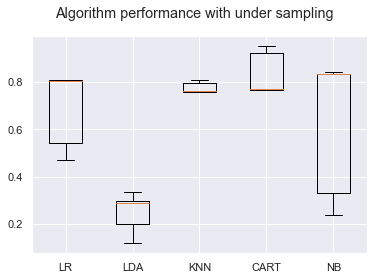

<Figure size 1152x648 with 0 Axes>

In [22]:
algorithm_comparison('Algorithm performance with under sampling')

### Ensemble methods

#### Algorithm benchmark with Under Sampling

In [23]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

ensembles = [('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train_over, y_train_over, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.844530 (0.056167)
GBM: 0.873757 (0.041386)
RFC: 0.881805 (0.061042)
ET: 0.866310 (0.046291)


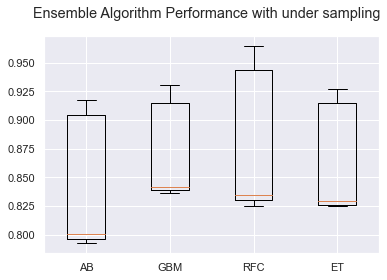

<Figure size 1152x648 with 0 Axes>

In [24]:
algorithm_comparison('Ensemble Algorithm Performance with under sampling')

## Selecting the best model

In [25]:
def run_tuned_random_forest(x_train, x_test, y_train, y_test):
    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    joblib.dump(model, '../../data/models/popularity.joblib')

In [26]:
run_tuned_random_forest(X_train_over, X_val_scaled, y_train_over, y_validation)

0.18604981780361698
[[     1 108782]
 [     0  24864]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    108783
           1       0.19      1.00      0.31     24864

    accuracy                           0.19    133647
   macro avg       0.59      0.50      0.16    133647
weighted avg       0.85      0.19      0.06    133647



In [27]:
def run_tuned_gradient_boosting(x_train, x_test, y_train, y_test):
    model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=80, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    joblib.dump(model, '../../data/models/popularity.joblib')

In [28]:
run_tuned_gradient_boosting(X_train_over, X_val_scaled, y_train_over, y_validation)

0.1860423354059575
[[     0 108783]
 [     0  24864]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    108783
           1       0.19      1.00      0.31     24864

    accuracy                           0.19    133647
   macro avg       0.09      0.50      0.16    133647
weighted avg       0.03      0.19      0.06    133647



/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

## Testing the created model to predict 2021 tweets popularity

In [29]:
test_2021 = df_2021_topics[variables_to_keep]
target = df_2021_topics['popularity']

In [30]:
popularity_model = joblib.load('../../data/models/popularity.joblib')
predictions = popularity_model.predict(test_2021)
print(accuracy_score(target, predictions))
print(confusion_matrix(target, predictions))
print(classification_report(target, predictions))

0.19368126397478422
[[     0 141721]
 [     0  34042]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    141721
           1       0.19      1.00      0.32     34042

    accuracy                           0.19    175763
   macro avg       0.10      0.50      0.16    175763
weighted avg       0.04      0.19      0.06    175763



/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control